## Machine Learning with Julia Interfacing Python

In [1]:
using Pkg
Pkg.activate("../..")
Pkg.instantiate()
using PyCall
using RCall
#using DecisionTree
using DataFrames
ENV["COLUMNS"]=1000; # for dataframe column size

┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1317


### R"" vs py"" String Macro

- R"" executes R commands inside the string and returns an R object 
- py"" executes Python commands with implicit conversion of python objects into Julia data type.

In [2]:
py"1+4" # returns julia numeric value by implicit conversion

5

In [3]:
R"result=1+1" # returns an RObject

RObject{RealSxp}
[1] 2


In [4]:
@rget result # use @rget macro to copy value from R to Julia

2.0

In [5]:
R"1+1" |> rcopy # or use rcopy to directoy convert R object into Julia data type 

2.0

### Defining a function in Python

In [6]:
py"""

import numpy as np

def mysin(x):
   return np.sin(x)
"""

In [7]:
py"mysin(10)" # calling python function

-0.5440211108893699

In [8]:
py"np.sin(10)"  # calling directly numpy sin function

-0.5440211108893699

In [9]:
pyimport("numpy").sin(10) # import numpy and call sin directly

-0.5440211108893699

### Defining a function in R

In [10]:
R"""
mysin <- function(x) {
   sin(x)
}
""";

In [11]:
R"mysin(10)" |> rcopy   # R"" returns an object which rcopy converts to Julia data

-0.5440211108893699

## Copying from-to R/Julia

In [12]:
iris = R"iris" |> rcopy # copy iris dataset from R to Julia
iris |> (x->first(x,5))

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [13]:
df = DataFrame(a=rand(5),b=rand(5)) # create dataframe

,a,b
,Float64,Float64
1,0.962206,0.850389
2,0.562167,0.971044
3,0.786401,0.203564
4,0.946357,0.255096
5,0.710502,0.571561


In [14]:
@rput df # copy df to R

,a,b
,Float64,Float64
1,0.962206,0.850389
2,0.562167,0.971044
3,0.786401,0.203564
4,0.946357,0.255096
5,0.710502,0.571561


In [15]:
R"df" # check if R got df

RObject{VecSxp}
          a         b
1 0.9622061 0.8503888
2 0.5621671 0.9710441
3 0.7864015 0.2035640
4 0.9463574 0.2550957
5 0.7105016 0.5715613


### Plotting with R and Python

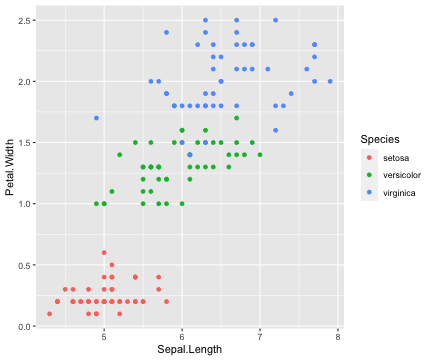

RObject{VecSxp}


In [16]:
R"""
library(ggplot2)

ggplot(iris,aes(x=Sepal.Length,y=Petal.Width))+geom_point(aes(color=Species))
"""

In [17]:
# won't run in binder
py"""
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()
"""

###   Scikitlearn classifiers using Julia bindings of Python (PyCall.jl)

Let's load the `car` dataset for this example.

We use `VegaDatasets` a collection of standard datasets popular in Julia. This data lives at https://github.com/vega/vega-datasets and https://cdn.jsdelivr.net/npm/vega-datasets.

In [ ]:
using VegaDatasets
cars=dataset("cars") |> DataFrame;
first(cars,5)

In [ ]:
@rput cars
cars = R"cars = cars[complete.cases(cars),]" |> rcopy;

In [ ]:
using PyCall
LNM = pyimport("sklearn.linear_model");
learner=LNM.LogisticRegression()

x=cars[:,[2,4,5,6,7]] |> Matrix
y=cars[:,:Cylinders] |> Array;

model=learner.fit(x, y)
yhat = model.predict(x)
accuracy = sum(yhat .== y) / length(y)
println("accuracy: $accuracy")

In [ ]:
R"table($yhat,$y)"

In [ ]:
learner

In [ ]:
using ScikitLearn.CrossValidation: cross_val_score

KNN = pyimport("sklearn.neighbors")

modelKNN = KNN.KNeighborsClassifier(3)

cross_val_score(modelKNN, x, y; cv=10)  # 5-fold

In [ ]:
using ScikitLearn.GridSearch: GridSearchCV

GS=pyimport("sklearn.model_selection");

lbgfs=LNM.LogisticRegression(multi_class="auto",solver="lbfgs")

In [ ]:
gridsearch = GS.GridSearchCV(lbgfs, Dict(:C => 0.1:0.1:2.0))
res=gridsearch.fit(x, y)
println("Best parameters: $(res.best_params_)")

In [ ]:
Cparams=convert.(Float64,res.cv_results_["param_C"])
score = res.cv_results_["std_test_score"]
R"plot($Cparams,$score,type='l')";

In [ ]:
using PyCall
const ENS=pyimport("sklearn.ensemble")
const LM=pyimport("sklearn.linear_model")
const DA=pyimport("sklearn.discriminant_analysis")
const NN=pyimport("sklearn.neighbors")
const SVM=pyimport("sklearn.svm")
const TREE=pyimport("sklearn.tree")
const ANN=pyimport("sklearn.neural_network")
const GP=pyimport("sklearn.gaussian_process")
const KR=pyimport("sklearn.kernel_ridge")
const NB=pyimport("sklearn.naive_bayes")
const ISO=pyimport("sklearn.isotonic")

In [ ]:
learners = Dict(
  "AdaBoostClassifier" => ENS.AdaBoostClassifier,
  "BaggingClassifier" => ENS.BaggingClassifier,
  "ExtraTreesClassifier" => ENS.ExtraTreesClassifier,
  "VotingClassifier" => ENS.VotingClassifier,
  "GradientBoostingClassifier" => ENS.GradientBoostingClassifier,
  "RandomForestClassifier" => ENS.RandomForestClassifier,
  "LDA" => DA.LinearDiscriminantAnalysis,
  "QDA" => DA.QuadraticDiscriminantAnalysis,
  "LogisticRegression" => LM.LogisticRegression,
  "PassiveAggressiveClassifier" => LM.PassiveAggressiveClassifier,
  "RidgeClassifier" => LM.RidgeClassifier,
  "RidgeClassifierCV" => LM.RidgeClassifierCV,
  "SGDClassifier" => LM.SGDClassifier,
  "KNeighborsClassifier" => NN.KNeighborsClassifier,
  "RadiusNeighborsClassifier" => NN.RadiusNeighborsClassifier,
  "NearestCentroid" => NN.NearestCentroid,
  "SVC" => SVM.SVC,
  "LinearSVC" => SVM.LinearSVC,
  "NuSVC" => SVM.NuSVC,
  "MLPClassifier" => ANN.MLPClassifier,
  "GaussianProcessClassifier" => GP.GaussianProcessClassifier,
  "DecisionTreeClassifier" => TREE.DecisionTreeClassifier,
  "GaussianNB" => NB.GaussianNB,
  "MultinomialNB" => NB.MultinomialNB,
  "ComplementNB" => NB.ComplementNB,
  "BernoulliNB" => NB.BernoulliNB
);

In [ ]:
function sktrain(learner,x,y)
    model = learner()
    xx = x |> Matrix
    yy = y |> Array
    model.fit(xx,yy)
    return model
end

In [ ]:
function skpredict(themodel,x)
    xx = x |> Matrix
    return themodel.predict(xx) |> collect
end

In [ ]:
R"""
library('caret')
cars = cars[complete.cases(cars),]
cars$Cylinders = as.factor(cars$Cylinders)

trainIndex <- createDataPartition(cars$Cylinders, p = .8,list=F)
train = cars[trainIndex,]
test = cars[-trainIndex,]
"""
@rget train test;

In [ ]:
xtrain=train[:,[2,4,5,6,7]] |> Matrix
ytrain=train[:,:Cylinders] |> Array;
xtest=test[:,[2,4,5,6,7]] |> Matrix
ytest=test[:,:Cylinders] |> Array;

### Try ExtraTrees Classifier

In [ ]:
modelLR = sktrain(learners["ExtraTreesClassifier"],xtrain,ytrain)
yhat = skpredict(modelLR,xtest);
acc=sum(yhat .== ytest) / length(yhat)

### Try AdaBoost Classifier

In [ ]:
modelLR = sktrain(learners["AdaBoostClassifier"],x,y)
res = skpredict(modelLR,x);
acc=sum(res .== y) / length(y)

### Try RandomForest Classifier

In [ ]:
modelLR = sktrain(learners["RandomForestClassifier"],x,y)
res = skpredict(modelLR,x);
acc=sum(res .== y) / length(y)

### Let's use R's Caret to predict Cars' Cylinders

In [ ]:
using RCall
R"""
library(caret)
library(e1071)
library(randomForest)
library(xgboost)
"""

In [ ]:
function crtrain(learner,x::DataFrame,y::Vector)
    xx = x |> DataFrame # DataFrame(x)
    yy = y |> Vector
    model = rcall(:train,xx,yy,method=learner)
    return model
end

In [ ]:
function crtpredict(model,x)
    xx = x |> DataFrame
    res = rcall(:predict,model,xx) #in robj
    return rcopy(res) |> collect  # return extracted robj
end

### Let's try RandForest in R

In [ ]:
xtrain=train[:,[2,4,5,6,7]] |> DataFrame
ytrain=train[:,:Cylinders] |> Array;
xtest=test[:,[2,4,5,6,7]] |> DataFrame
ytest=test[:,:Cylinders] |> Array;

In [ ]:
crtmodel = crtrain("rf",xtrain,ytrain)
ypred = crtpredict(crtmodel,xtest);
acc = sum(ypred .== ytest) / length(ytest)

In [ ]:
crtmodel = crtrain("svmRadial",xtrain,ytrain)
ypred = crtpredict(crtmodel,xtest) 
sum(ypred .== ytest) / length(ytest)

In [ ]:
crtmodel = crtrain("treebag",xtrain,ytrain)
ypred = crtpredict(crtmodel,xtest) 
sum(ypred .== ytest) / length(ytest)